In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.insert(0, os.path.abspath('../src'))
from shallowwater import (ModelParams, make_grid, setup_initial_state,
                          zero_forcing, run_model, compute_dt_cfl)
# If you exported it at top-level:
from shallowwater import geostrophic_velocities_from_eta
# Otherwise (as you mentioned) it lives in initial.py:
# from shallowwater.initial import geostrophic_velocities_from_eta

import numpy as np


In [2]:
# Initial condition: nearly geostrophic Gaussian at mid-latitude, east of center
def ic_rossby_bump(g, p,
                   amp=0.15,                   # meters
                   R=None,                     # set to Ld by default
                   x0=None, y0=None,
                   degree_of_balance=1,     # 1 = fully geo, <1 leaves a touch of IG
                   alpha=0.95, sponge=6):
    if R  is None: R  = Ld
    if x0 is None: x0 = 0.5*g.Lx             # start in the east to watch westward propagation
    if y0 is None: y0 = p.y0                  # mid-lat line (f ≈ f0)

    # eta field
    eta0, _, _ = setup_initial_state(g, p, mode="gaussian_bump", amp=amp, R=R, x0=x0, y0=y0)
    eta0 -= eta0.mean()
    # geostrophic (u,v) from eta, scaled
    u0, v0 = geostrophic_velocities_from_eta(eta0, g, p,
                                             degree_of_balance=degree_of_balance,
                                             alpha=alpha, sponge=sponge)
    return eta0, u0, v0

### Eddy with radius = Ld

In [3]:
# --- Mid-latitude Rossby wave from a balanced Gaussian bump ---

# Basin & grid
Nx, Ny = 192, 128
Lx, Ly = 4.0e6, 3.0e6     # 4000 x 3000 km
grid = make_grid(Nx, Ny, Lx, Ly)

# Mid-latitude β-plane, mild Rayleigh (damp IG waves, keep Rossby clean), linear dynamics
params = ModelParams(H=100.0, g=9.81, rho=1025.0,
                     f0=1.0e-4, beta=2.0e-11, y0=Ly/2,
                     r=1/(15*86400),  # ~15-day e-fold
                     linear=True)

# Useful scales
c0   = np.sqrt(params.g*params.H)              # external gravity-wave speed [m/s]
Ld   = c0/params.f0                            # barotropic deformation radius [m]
cR   = -params.beta * Ld**2                    # long barotropic Rossby phase speed [m/s] (westward)
print(f"Ld ≈ {Ld/1e3:.0f} km,  c_R ≈ {cR:.2f} m/s ({cR*86400/1e3:.1f} km/day)")

# Stable time step
dt = compute_dt_cfl(grid, params, cfl=0.5)

# Initial condition: nearly geostrophic Gaussian at mid-latitude, east of center
ic_fn = lambda g, p: ic_rossby_bump(g, p, R=Ld)

# No forcing
forcing_fn = lambda t, g, p: zero_forcing(t, g, p)

# Long enough to cross a good fraction of the basin at |cR|
tmax = 20 * 86400.0    # 20 days

# Save ~200 frames
N = int(np.ceil(tmax/dt))
save_every = max(1, int(round(N/199)))

out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=save_every, out_vars=("eta","u","v"))
print("Saved steps:", len(out["time"]))


Ld ≈ 313 km,  c_R ≈ -1.96 m/s (-169.5 km/day)
Saved steps: 200


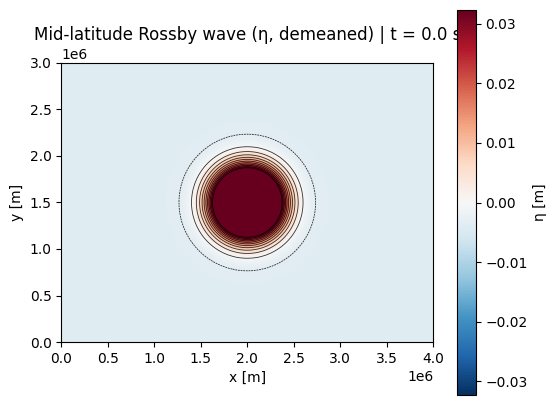

In [4]:
from shallowwater.visualize import animate_eta

anim = animate_eta(out, grid, interval=80, contours=True, contour_levels=21,
                   title="Mid-latitude Rossby wave (η, demeaned)")

# GIF (no external dependencies)
anim.save("eta_11_medium_eddy.gif", fps=10)

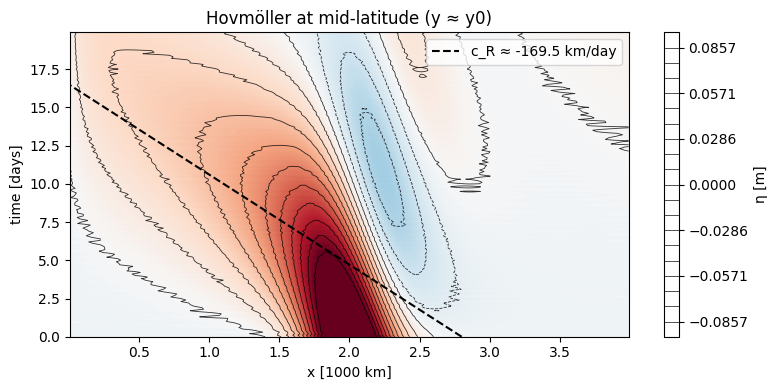

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Stack and extract a mid-latitude Hovmöller
ETA  = np.stack(out["eta"])                 # (T, Ny, Nx)
tt   = np.array(out["time"])                # s
jj   = np.argmin(np.abs(grid.y_c - params.y0))  # closest to mid-lat
hov  = ETA[:, jj, :]                        # η(x,t) at y = y0

# Axes in convenient units: x in 10^6 m (= 1000 km), time in days
Xc_Mm  = grid.x_c / 1e6                     # centers along x (millions of meters)
T_days = tt / 86400.0

# Symmetric limits around zero (nice for red/blue)
vmax_abs = float(np.nanpercentile(np.abs(hov), 98.0))
if vmax_abs == 0.0:
    vmax_abs = 1e-6
vmin, vmax = -vmax_abs, vmax_abs
levels = np.linspace(vmin, vmax, 21)

plt.figure(figsize=(8, 4))

# Image background (use extent to align with physical axes)
ext = (Xc_Mm[0], Xc_Mm[-1], T_days[0], T_days[-1])
plt.imshow(hov, aspect="auto", origin="lower", extent=ext,
           cmap="RdBu_r", vmin=vmin, vmax=vmax)

# Contours over the same field in physical coordinates
XX, TT = np.meshgrid(Xc_Mm, T_days)
plt.contour(XX, TT, hov, levels=levels, colors="k", linewidths=0.6, alpha=0.8)

plt.colorbar(label="η [m]")
plt.xlabel("x [1000 km]")    # 1 on the x-axis = 1000 km
plt.ylabel("time [days]")
plt.xlim([Xc_Mm[0], Xc_Mm[-1]])
plt.title("Hovmöller at mid-latitude (y ≈ y0)")

# Overlay a long-wave Rossby ray: x(t) = x0 + cR * t
x0_units = 0.70 * grid.Lx / 1e6               # same units as x-axis (10^6 m)
t_ray    = np.linspace(T_days[0], T_days[-1], 200)
x_ray    = x0_units + (cR * (t_ray * 86400.0)) / 1e6
plt.plot(x_ray, t_ray, "k--", lw=1.5, label=f"c_R ≈ {cR*86400/1e3:.1f} km/day")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


### Large Eddy with radius = 3*Ld

In [6]:
# --- Mid-latitude Rossby wave from a balanced Gaussian bump ---

# Basin & grid
Nx, Ny = 192, 128
Lx, Ly = 4.0e6, 3.0e6     # 4000 x 3000 km
grid = make_grid(Nx, Ny, Lx, Ly)

# Mid-latitude β-plane, mild Rayleigh (damp IG waves, keep Rossby clean), linear dynamics
params = ModelParams(H=100.0, g=9.81, rho=1025.0,
                     f0=1.0e-4, beta=2.0e-11, y0=Ly/2,
                     r=1/(15*86400),  # ~15-day e-fold
                     linear=True)

# Useful scales
c0   = np.sqrt(params.g*params.H)              # external gravity-wave speed [m/s]
Ld   = c0/params.f0                            # barotropic deformation radius [m]
cR   = -params.beta * Ld**2                    # long barotropic Rossby phase speed [m/s] (westward)
print(f"Ld ≈ {Ld/1e3:.0f} km,  c_R ≈ {cR:.2f} m/s ({cR*86400/1e3:.1f} km/day)")

# Stable time step
dt = compute_dt_cfl(grid, params, cfl=0.5)

# Initial condition: nearly geostrophic Gaussian at mid-latitude, east of center
ic_fn = lambda g, p: ic_rossby_bump(g, p, R=3*Ld)

# No forcing
forcing_fn = lambda t, g, p: zero_forcing(t, g, p)

# Long enough to cross a good fraction of the basin at |cR|
tmax = 20 * 86400.0    # 20 days

# Save ~200 frames
N = int(np.ceil(tmax/dt))
save_every = max(1, int(round(N/199)))

out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=save_every, out_vars=("eta","u","v"))
print("Saved steps:", len(out["time"]))


Ld ≈ 313 km,  c_R ≈ -1.96 m/s (-169.5 km/day)
Saved steps: 200


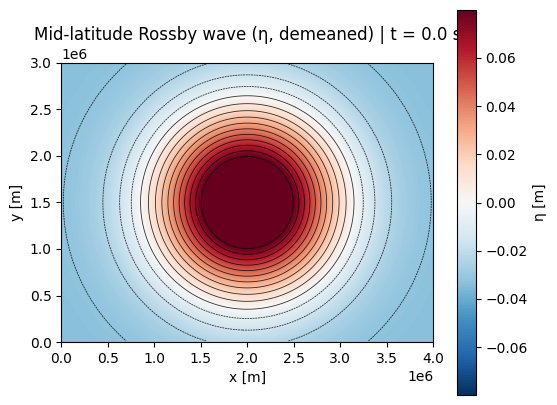

In [7]:
from shallowwater.visualize import animate_eta

anim = animate_eta(out, grid, interval=80, contours=True, contour_levels=21,
                   title="Mid-latitude Rossby wave (η, demeaned)")

# GIF (no external dependencies)
anim.save("eta_11_large_eddy.gif", fps=10)

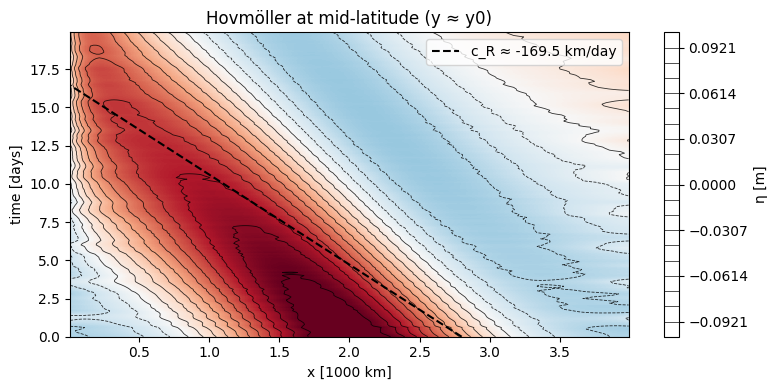

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Stack and extract a mid-latitude Hovmöller
ETA  = np.stack(out["eta"])                 # (T, Ny, Nx)
tt   = np.array(out["time"])                # s
jj   = np.argmin(np.abs(grid.y_c - params.y0))  # closest to mid-lat
hov  = ETA[:, jj, :]                        # η(x,t) at y = y0

# Axes in convenient units: x in 10^6 m (= 1000 km), time in days
Xc_Mm  = grid.x_c / 1e6                     # centers along x (millions of meters)
T_days = tt / 86400.0

# Symmetric limits around zero (nice for red/blue)
vmax_abs = float(np.nanpercentile(np.abs(hov), 98.0))
if vmax_abs == 0.0:
    vmax_abs = 1e-6
vmin, vmax = -vmax_abs, vmax_abs
levels = np.linspace(vmin, vmax, 21)

plt.figure(figsize=(8, 4))

# Image background (use extent to align with physical axes)
ext = (Xc_Mm[0], Xc_Mm[-1], T_days[0], T_days[-1])
plt.imshow(hov, aspect="auto", origin="lower", extent=ext,
           cmap="RdBu_r", vmin=vmin, vmax=vmax)

# Contours over the same field in physical coordinates
XX, TT = np.meshgrid(Xc_Mm, T_days)
plt.contour(XX, TT, hov, levels=levels, colors="k", linewidths=0.6, alpha=0.8)

plt.colorbar(label="η [m]")
plt.xlabel("x [1000 km]")    # 1 on the x-axis = 1000 km
plt.ylabel("time [days]")
plt.xlim([Xc_Mm[0], Xc_Mm[-1]])
plt.title("Hovmöller at mid-latitude (y ≈ y0)")

# Overlay a long-wave Rossby ray: x(t) = x0 + cR * t
x0_units = 0.70 * grid.Lx / 1e6               # same units as x-axis (10^6 m)
t_ray    = np.linspace(T_days[0], T_days[-1], 200)
x_ray    = x0_units + (cR * (t_ray * 86400.0)) / 1e6
plt.plot(x_ray, t_ray, "k--", lw=1.5, label=f"c_R ≈ {cR*86400/1e3:.1f} km/day")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()


### Small Eddy with radius = Ld/3

In [9]:
# --- Mid-latitude Rossby wave from a balanced Gaussian bump ---

# Basin & grid
Nx, Ny = 192, 128
Lx, Ly = 4.0e6, 3.0e6     # 4000 x 3000 km
grid = make_grid(Nx, Ny, Lx, Ly)

# Mid-latitude β-plane, mild Rayleigh (damp IG waves, keep Rossby clean), linear dynamics
params = ModelParams(H=100.0, g=9.81, rho=1025.0,
                     f0=1.0e-4, beta=2.0e-11, y0=Ly/2,
                     r=1/(15*86400),  # ~15-day e-fold
                     linear=True)

# Useful scales
c0   = np.sqrt(params.g*params.H)              # external gravity-wave speed [m/s]
Ld   = c0/params.f0                            # barotropic deformation radius [m]
cR   = -params.beta * Ld**2                    # long barotropic Rossby phase speed [m/s] (westward)
print(f"Ld ≈ {Ld/1e3:.0f} km,  c_R ≈ {cR:.2f} m/s ({cR*86400/1e3:.1f} km/day)")

# Stable time step
dt = compute_dt_cfl(grid, params, cfl=0.5)

# Initial condition: nearly geostrophic Gaussian at mid-latitude, east of center
ic_fn = lambda g, p: ic_rossby_bump(g, p, R=Ld/3)

# No forcing
forcing_fn = lambda t, g, p: zero_forcing(t, g, p)

# Long enough to cross a good fraction of the basin at |cR|
tmax = 20 * 86400.0    # 20 days

# Save ~200 frames
N = int(np.ceil(tmax/dt))
save_every = max(1, int(round(N/199)))

out = run_model(tmax, dt, grid, params, forcing_fn, ic_fn,
                save_every=save_every, out_vars=("eta","u","v"))
print("Saved steps:", len(out["time"]))


Ld ≈ 313 km,  c_R ≈ -1.96 m/s (-169.5 km/day)
Saved steps: 200


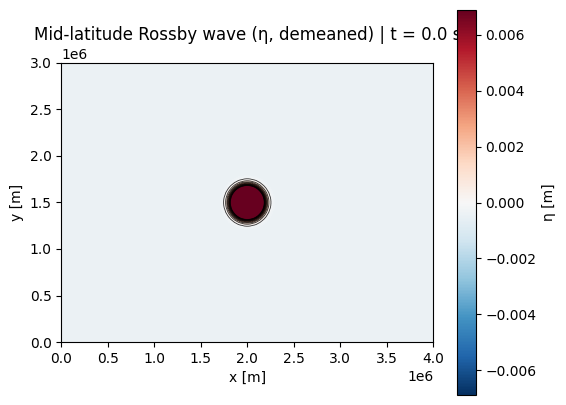

In [10]:
from shallowwater.visualize import animate_eta

anim = animate_eta(out, grid, interval=80, contours=True, contour_levels=21,
                   title="Mid-latitude Rossby wave (η, demeaned)")

# GIF (no external dependencies)
anim.save("eta_11_small_eddy.gif", fps=10)

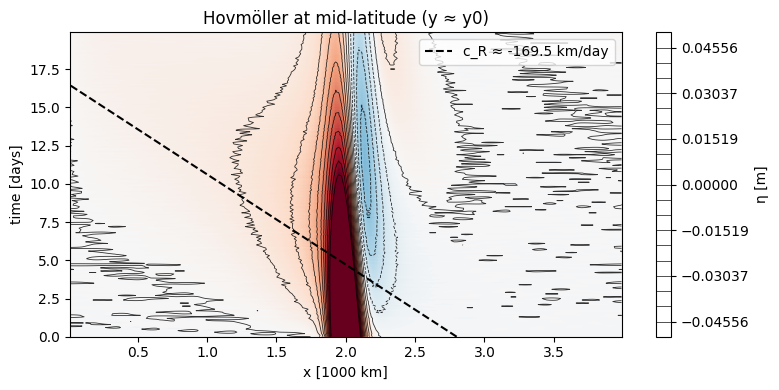

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Stack and extract a mid-latitude Hovmöller
ETA  = np.stack(out["eta"])                 # (T, Ny, Nx)
tt   = np.array(out["time"])                # s
jj   = np.argmin(np.abs(grid.y_c - params.y0))  # closest to mid-lat
hov  = ETA[:, jj, :]                        # η(x,t) at y = y0

# Axes in convenient units: x in 10^6 m (= 1000 km), time in days
Xc_Mm  = grid.x_c / 1e6                     # centers along x (millions of meters)
T_days = tt / 86400.0

# Symmetric limits around zero (nice for red/blue)
vmax_abs = float(np.nanpercentile(np.abs(hov), 98.0))
if vmax_abs == 0.0:
    vmax_abs = 1e-6
vmin, vmax = -vmax_abs, vmax_abs
levels = np.linspace(vmin, vmax, 21)

plt.figure(figsize=(8, 4))

# Image background (use extent to align with physical axes)
ext = (Xc_Mm[0], Xc_Mm[-1], T_days[0], T_days[-1])
plt.imshow(hov, aspect="auto", origin="lower", extent=ext,
           cmap="RdBu_r", vmin=vmin, vmax=vmax)

# Contours over the same field in physical coordinates
XX, TT = np.meshgrid(Xc_Mm, T_days)
plt.contour(XX, TT, hov, levels=levels, colors="k", linewidths=0.6, alpha=0.8)

plt.colorbar(label="η [m]")
plt.xlabel("x [1000 km]")    # 1 on the x-axis = 1000 km
plt.ylabel("time [days]")
plt.xlim([Xc_Mm[0], Xc_Mm[-1]])
plt.title("Hovmöller at mid-latitude (y ≈ y0)")

# Overlay a long-wave Rossby ray: x(t) = x0 + cR * t
x0_units = 0.70 * grid.Lx / 1e6               # same units as x-axis (10^6 m)
t_ray    = np.linspace(T_days[0], T_days[-1], 200)
x_ray    = x0_units + (cR * (t_ray * 86400.0)) / 1e6
plt.plot(x_ray, t_ray, "k--", lw=1.5, label=f"c_R ≈ {cR*86400/1e3:.1f} km/day")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()
